# VQC Challenge

## Submission Summary

### Todo 1:
For this first task, we need to implement the feature map presented in Havlíček et al. which is given by:

$$U_{\Phi(\textbf{x})} = \exp\bigg(i \sum_{S \subseteq [n]} \phi_S(\textbf{x}) \prod_{i \in S} Z_i \bigg) \quad \text{(*)}$$

Where: $[n]$ is the powerset of $n$, and $n$ is the number of qubits in our circuit.  In this example $n = 2$ which means:

$$[n] = \{\{0\}, \{1\}, \{0, 0\}\} \qquad \text{we started counting from index 0}$$

and we have chosen: $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

The expression $\text{(*)}$ can be simplified as:

$$\begin{align}
U_{\Phi(\textbf{x})} &= \exp\bigg(i \left(\phi_0(\textbf{x}) Z_0 + \phi_1(\textbf{x}) Z_1 + \phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \right)\bigg) \\
 &= \exp\big(i \phi_0(\textbf{x}) Z_0\big)  \exp\big(i\phi_1(\textbf{x}) Z_1\big) \exp\big(i\phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \big) \\
 &= Rz_0\big(\phi_0(\textbf{x})\big) \; Rz_1\big(\phi_1(\textbf{x})\big) \; CNOT_{\{0, 1\}} \; Rz_1\big(\phi_{\{0, 1\}}(\textbf{x})\big) \; CNOT_{\{0, 1\}}
 \end{align}$$

The use the fact that $\exp(i \theta Z) = Rz\big(\theta\big)$, because Pauli matrices $X, Y, Z$ are generators of rotations. The subscript indicates which qubit the gates is executed on.

Now, that we have the expression for $U_{\Phi(\textbf{x})}$, we just need to implement it using pennylane.

Note that we have to repeat the circuit $H^{n} U_{\Phi(\textbf{x})}$ 2 times as presented by Havlíček et al.

### Todo 2:
Second, we need to fix the ansatz. We can easily read the ansatz from the fig. 2 B of Havlíček et al.

Our variationnal circuit starts by rotations [$U_3$](https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html) on each qubit. 

Then, we have $l$ layers (we are using the letter $d$ instead) of $CZ$ gates between $(i, j) \in E$ followed by a $U_3$ rotation on each qubit.

In order to have the maximum flexibility, we are dynamically feeding the depth to the ansatz. This allows us to adapt the ansatz to the `params` tensor that it received.

### Todo 3:
There are four important features that we added in our training:

* **Warm start**: we try to pick good initial set of params to lower the number of iterations needed
* **Adaptative Learning**: we are changing the stepsize (learning_rate) during the training to ensure a fast and precise training
* **Early stoppage**: we added an early stoppage routine to save some of the training cost (financial cost) in case the model is doing well
* **Validation set**: to monitor how our model is performing during the training

Details of each feature can be found in the `train` function implemented below.

**/!\ Remark**: Please take the early stoppage (financial) cost into consideration when early stoppage happens during the training.

### Todo 4:

Executing the circuit on AWS is very straightforward and easy thanks to qBraid 😀!

In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
TEAM_NAME = "CQTech"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## Load and visualize dataset

To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

This binary dataset has been artificially generated to be perfectly classifiable using a suitable feature map.

In [4]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [5]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_test_ext, Y_test_ext = Xs[n_samples:], Ys[n_samples:]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

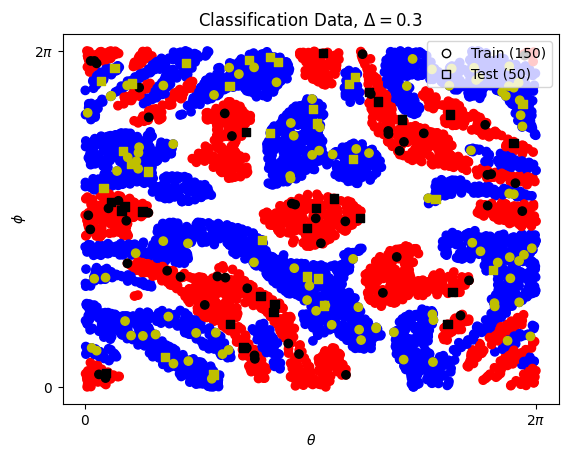

In [6]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.savefig(DATA_PATH + "binary_landscape.png")
plt.show()

An arbitrary single qubit state can be written:

$$\left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

## Construct data encoding feature map with entanglement $\left| \Phi(x_i) \right\rangle \left\langle \Phi(x_i) \right|  $

In [7]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [8]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [9]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

### <span style="color:red">TODO (1): Fix incorrect feature map</span>

For this first task, we need to implement the feature map presented in Havlíček et al. which is given by:

$$U_{\Phi(\textbf{x})} = \exp\bigg(i \sum_{S \subseteq [n]} \phi_S(\textbf{x}) \prod_{i \in S} Z_i \bigg) \quad \text{(*)}$$

Where: $[n]$ is the powerset of $n$ and $n$ is the number of qubits in our circuit.  In this example $n = 2$ which means:

$$[n] = \{\{0\}, \{1\}, \{0, 0\}\} \qquad \text{we started counting from index 0}$$

and we have chosen: $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

The expression $\text{(*)}$ can be simplified as:

$$\begin{align}
U_{\Phi(\textbf{x})} &= \exp\bigg(i \left(\phi_0(\textbf{x}) Z_0 + \phi_1(\textbf{x}) Z_1 + \phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \right)\bigg) \\
 &= \exp\bigg(i \left(\phi_0(\textbf{x}) Z_0 + \phi_1(\textbf{x}) Z_1 + \phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \right)\bigg) \\
 &= \exp\big(i \phi_0(\textbf{x}) Z_0\big) + \exp\big(i\phi_1(\textbf{x}) Z_1\big) + \exp\big(i\phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \big) \\
 &= Rz\big(\phi_0(\textbf{x})\big) \; Rz\big(\phi_1(\textbf{x})\big) \; CNOT\big(0, 1\big) \; Rz\big(\phi_{\{0, 1\}}(\textbf{x})\big) \; CNOT\big(0, 1\big)
 \end{align}$$

The use the fact that $\exp(i \theta Z) = Rz\big(\theta\big)$, because Pauli matrices $X, Y, Z$ are generators of rotations.

Now, that we have the expression for $U_{\Phi(\textbf{x})}$, we just need to implement it using pennylane.

Note that we have to repeat the circuit $H^{n} U_{\Phi(\textbf{x})}$ 2 times as presented by Havlíček et al.

In [10]:
def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        for i in range(n_wires):
            qml.Hadamard(wires=i)

        for i in range(n_wires):
            qml.RZ(-2 * x[i], wires=i)

        for s in pset:
            qml.CNOT(wires=s)
            qml.RZ(-2 * x[2], wires=1)
            qml.CNOT(wires=s)

## Construct short-depth discriminator circuit $W(\theta)$

The general short-depth circuit to define a seperating hyperplane is comprised of the following sequence of single qubit and multi-qubit gates:

$$ W(\theta) = U_{loc}^{(l)}(\theta_l)U_{ent}...U_{loc}^{(2)}(\theta_2)U_{ent}U_{loc}^{(1)}(\theta_1) $$


Apply a circuit of $l$ repeated entanglers and interleave them with layers comprised of local single qubit rotations:

$$ U_{loc}^{(t)}(\theta_t) = \otimes_{m=1}^n U(\theta_{m,t}) \quad \text{and} \quad U(\theta_{m,t}) = \exp\bigg(i \frac{1}{2}\theta_{m,t}^z Z_m\bigg) \exp\bigg(i \frac{1}{2}\theta_{m,t}^y Y_m\bigg) $$

parameterized by $\theta_t \in {\rm I\!R}^{2n}$ and $\theta_{i,t} \in {\rm I\!R}^{2}$. Implement a feature map that uses entangling unitaries comprised of products of controlled-Z phase gates $CZ(i,j)$ between qubits $i$ and $j$.

$$ U_{ent} = \prod_{(i,j) \in E} CZ(i,j) $$ 

### <span style="color:red">TODO (2): Fix incorrect ansatz</span>

Second, we need to fix the ansatz. We can easily read the ansatz from the fig. 2 B of Havlíček et al.

Our variationnal circuit starts by rotations [$U_3$](https://qiskit.org/documentation/stubs/qiskit.circuit.library.U3Gate.html) on each qubit. 

Then, we have $l$ layers (we are using the letter $d$ instead) of $CZ$ gates followed by a $U_3$ rotation on each qubit.

In order to have the maximum flexibility, we are dynamically feeding the depth to the ansatz. This allows us to adapt the ansatz to the `params` tensor that it received.

In [11]:
def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    depth = params.shape[0] - 1 # getting the depth dynamically
    
    for i in range(n_wires):
        qml.Rot(params[0, i, 0], params[0, i, 1], params[0, i, 2], wires=i)

    for d in range(depth):
        for s in pset:
            qml.CZ(wires=s)

        for i in range(n_wires):
            qml.Rot(params[d + 1, i, 0], params[d + 1, i, 1], params[d + 1, i, 2], wires=i)

### <span style="color:red">TODO (3): Adapt circuit implementation to fixes (1) and (2)</span>

Our circuit will consist of the feature map constructed above followed by the variationnal circuit. This can easily be implemented as:

In [12]:
def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """
    
    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))  # p(+1), p(-1)

In [13]:
dev_local = qml.device("default.qubit", wires=n_wires)
qnode_local = qml.QNode(circuit, dev_local)

In this example, we can see that we are constructing a circuit of depth 1.

(<Figure size 1600x300 with 1 Axes>, <Axes: >)

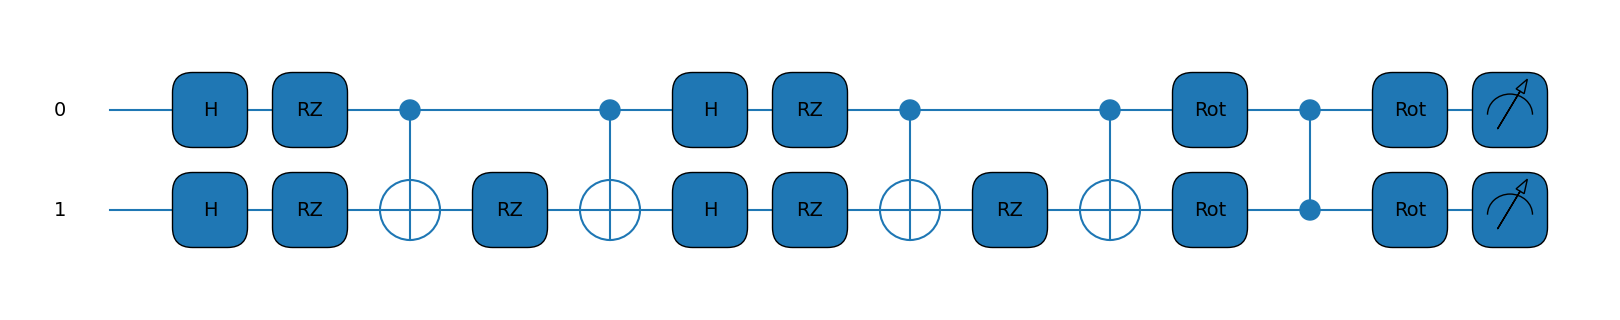

In [14]:
depth = 1

params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

qml.draw_mpl(qnode_local)(params, X_train[0])

In this example, we can see that we are constructing a circuit of depth 3.

(<Figure size 2000x300 with 1 Axes>, <Axes: >)

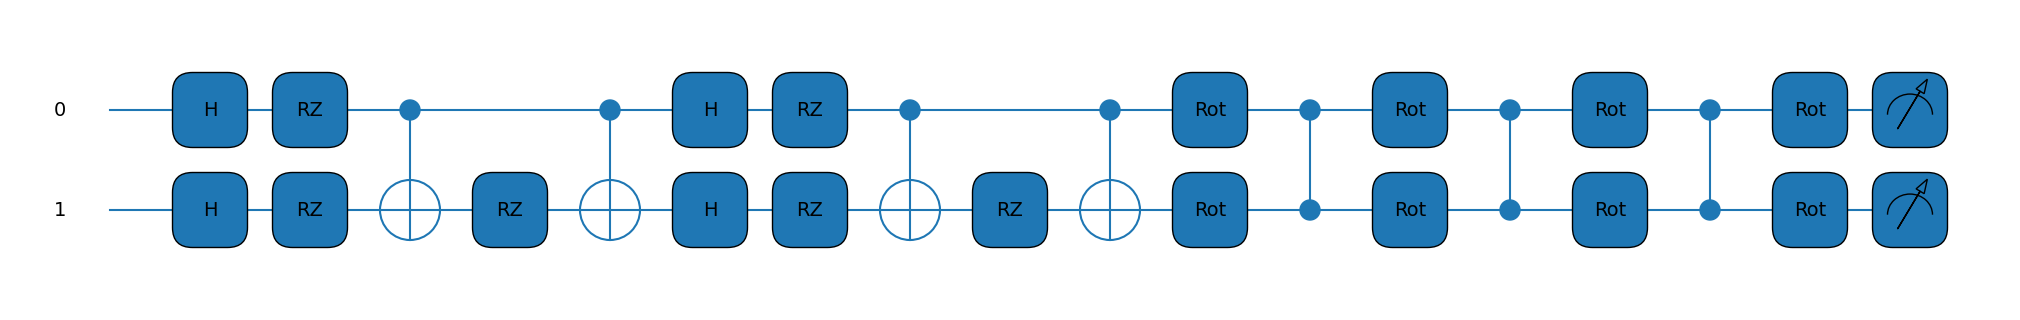

In [15]:
depth = 3

params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

qml.draw_mpl(qnode_local)(params, X_train[0])

## Train model

In [16]:
def err_prob(params, x, y, R, qnode):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct )) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

In [17]:
def cost(params, Xs, Ys, R, qnode):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R, qnode)

    return ep_sum / Xs.shape[0]  # return average over all data points

We built a function that allows us to predict the label starting the input $\textbf{x}$ 

In [18]:
def predict(params, x, qnode):
        bprobs = qnode(params, x) 
        prob = bprobs[0] + bprobs[3]
        if prob >= 0.5:
             return 1.0
        return -1.0

Next, we built a function that can evaluate the accuracy of our circuit

In [19]:
def evaluate(params, x_eval, y_eval, qnode):
    """Evaluates the accuracy of the model by testing it on a chosen set.

        Parameters
        ----------
            params : tensor
                Model's parameters.
            x_eval : tensor
                List of testing inputs.
            y_eval : tensor
                Expected outputs.
            qnode : qml.QNode
                The quantum node in the hybrid computational graph.

        Returns
            -------
            accuracy : float
                The ratio of the number of correct predictions and the total
                number of predictions.
    """
    
    y_pred = np.zeros(shape=y_eval.shape)

    for ind, x in enumerate(x_eval):
        y_pred[ind] = predict(params, x, qnode)

    preds = np.asarray(y_pred == y_eval, dtype=int)

    n_preds = len(y_pred)
    n_correct = sum(preds).item()
    n_incorrect = n_preds - n_correct
    accuracy = n_correct / n_preds

    return accuracy

We also built functions that estimate the cost of the training and the cost ($$$) per prediction

In [20]:
def quantum_cost_train(iterations, batch_size, shots):
    """Returns the cost in dollars of training the model on Rigetti's
    device.

        Parameters
        ----------
            iterations : int
                Number of training iterations.
            batch_size : int
                Number of training examples used in one iteration.
            shots : int
                Number of times the circuit is executed.

        Returns
        -------
            float
                The cost in dollars to train the model on Rigetti's device (on AWS).
    """
    return iterations * batch_size * (0.3 + shots * 0.00035)

In [21]:
def quantum_cost_pred(shots):
    """Returns the cost in dollars for making a single prediction
    on Rigetti's device using the trained model.

        Parameters
        ----------
            shots : int
                Number of times the circuit is executed.

        Returns
        -------
            float
                The cost in dollars for making a prediction on Rigetti's device.
    """
    return 0.3 + shots * 0.00035

Next, our main function which is the training function

In [22]:
def train(X, Y, depth, optimizers, iterations, batch_size, shots):
    """Trains a model on a set of labeled data points using VQC.

        Parameters
        ----------
            X : tensor
                Input data.
            Y : tensor
                Expected outcome.
            depth : int
                Number of layers in the variational circuit.
            optimizers : list
                A list of optimizers (look at the comments below).
            iterations : int
                Number of training iterations.
            batch_size : int
                Number of training examples used in one iteration.
            shots : int
                Number of times the circuit is executed.

        Returns
        -------
            model : dict
                The trained model as a dictionary of parameters and properties.
    """
    
    # As the number of shots is a hyperparameter of our model, we need to initiate the device in here
    dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)
    qnode_local = qml.QNode(circuit, dev_local)
    
    # We are creating a validation set to monitor the performance of our model
    # And make sure that our model is not overfitting
    # The validation set is 10% of the inputted training set
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.1)
                             
    # The X_train and Y_train aren't trainable parameters so we disable the calculation of their gradients
    X_train.requires_grad = False
    Y_train.requires_grad = False
    
    # The next step is a VERY important step in our model
    # We randomly pick 15 sets of parameters, compute their costs (loss), and start to train the best one.
    # This allows us to avoid starting with a bad set of params which will heavily increase the time and cost ($$$) of our model

    # Picking the best initial parameters
    params_dict = {}
    warm_start = 15 # We can increase or decrease this number, it represents the initial set that we want to generate
    for i in range(warm_start):
            params = (
                2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
            )  # random initial circuit parameters
            params_dict[cost(params, X_train, Y_train, shots, qnode_local).item()] = np.copy(params)
    
    # Printing the cost (loss) of our warm start set
    print("Warm list costs:", params_dict.keys())
    print()
    
    # Picking the best initial params
    cost_current = sorted(list(params_dict.keys()))[0] 
    params = params_dict[cost_current]
    
    # Printing the cost ($$$) of our model
    # Note that the warm start gives a little overhead in cost (of 5.55$) but it is an overhead that we judge completely worth having
    # Actually, it allows us to have less variability on the necessary on the iterations/batch_size 
    qct1 = quantum_cost_train(iterations, batch_size, shots) + quantum_cost_train(1, warm_start, shots) 
    print(f"The training quantum cost is: {qct1:.2f}$")
    
    
    # Monitoring data
    costs = [cost_current]
    accis = [evaluate(params, X_valid, Y_valid, qnode_local)]
    times = [0]
    
    # Another VERY important aspect of our model is that we are training using multiple optimizers
    # Here is the reason of that:
    # First, we start we an optimizer with a big stepsize (learning_rate), this allows us to quickly reach a rather low cost
    # Then we switch to other optimizers with lower and lower stepsizes (learning_rates) so that we are able to reach the optimal
    # parameters without overshooting
    
    # We are aware that there is some optimizers that aim to do that (adaptive learning) 
    # like AdamOptimizer and AdagradOptimizer but using this three optimizers technique worked best for us
    
    nb_optimizers = len(optimizers)
    curr_optimizer = 0
    optimizer = optimizers[curr_optimizer]
    
    for i in tqdm(range(iterations), desc="training", leave=False):
        
        # We start with optimizer 0 then 1 and then 2
        # By default, the iterations are equally distributed on each optimizer
        # We added some condition to switch to a better optimizer earlier 
        # whenever we judge that the previous one achieved (relatively) good results
        
        new_optimizer = i // (iterations // nb_optimizers) 
        if costs[-1] < 0.03:
            new_optimizer = max([new_optimizer, 2])
        elif costs[-1] < 0.1:
            new_optimizer = max([new_optimizer, 1])
        
                
        if curr_optimizer != new_optimizer:
            curr_optimizer = np.min([len(optimizers) - 1, new_optimizer])
            optimizer = optimizers[curr_optimizer]
            print("\nSwitching to optimizer:", curr_optimizer)
            
            
        # Generate the batch
        batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
        X_batch = X_train[batch_index]
        Y_batch = Y_train[batch_index]

        t0 = time.time()

        # Update parameters by a single step.
        params = optimizer.step(lambda var: cost(var, X_batch, Y_batch, shots, qnode_local), params)

        t1 = time.time()
        
        # Compute cost
        cost_current = cost(params, X_train, Y_train, shots, qnode_local)
        # Computing the accuracy on the validation set
        acc_valid = evaluate(params, X_valid, Y_valid, qnode_local)
        
        print(f"Epoch: {i + 1:2d} | Cost: {cost_current:1.4f} | Accuracy: {acc_valid:.2%}")
        
        costs.append(cost_current.item())
        accis.append(acc_valid)
        times.append(t1 - t0)
        
        # One last important thing is early stoppage
        # If our cost (loss) is below 0.01 and the accuracy is 100% then we can stop our training
        # This allows us to save some bucks ($$$) in case we were too generous in our choice of iterations
        
        
        if costs[-1] < 0.012 and accis[-1] == 1.0:
            print("Early stoppage")
            qct1 = quantum_cost_train(i + 1, batch_size, shots) + quantum_cost_train(1, warm_start, shots) 
            print(f"\n\nThe (REAL) training quantum cost is: {qct1:.2f}$\n\n")
            # **/!\ Remark**: Please take the early stoppage (financial) cost into consideration when early stoppage happens.
            break
            

    print(f"Initial cost: {round(float(costs[0]), 4)}")
    print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
    print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")
    acc = evaluate(params, X_test, Y_test, qnode_local)
    print(f"Evaluation on the test set: {acc:2%}")
    
    
    # Finally, we return our model with the all the necessary information for someone else to recreate it
    model = {"params": params, "costs": costs, "times": times, 
             "iterations": iterations, "batch_size": batch_size, 
             "shots": shots, "depth": depth, "quantum_cost": qct1,
             "accuracies": accis}
    
    return model

Next, we choose the following hyperparameters for our model:

In [23]:
depth = 5

# We are using three optimizers as stated in the comments in the train function above
# This allows us to have a quick and precise training

optimizers = [qml.GradientDescentOptimizer(0.5), 
              qml.GradientDescentOptimizer(0.2), 
              qml.GradientDescentOptimizer(0.1)]

iterations = 30
batch_size = 7
shots = 200

And we start training our model:

In [25]:
# **/!\ Remark**: Please take the early stoppage (financial) cost into consideration when early stoppage happens.
model = train(X_train, Y_train, depth, optimizers, iterations, batch_size, shots)

Warm list costs: dict_keys([0.5683464133077504, 0.4871437724768157, 0.6314690555550306, 0.6288242489314869, 0.30087420732226494, 0.26201472176847845, 0.24707948266870383, 0.8259451691161755, 0.1989102319800026, 0.7545383121256195, 0.48040025602848846, 0.7082850069681497, 0.38761174609469856, 0.6763325089212332, 0.6941195181061958])

The training quantum cost is: 83.25$


training:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  1 | Cost: 0.4464 | Accuracy: 60.00%
Epoch:  2 | Cost: 0.3177 | Accuracy: 80.00%
Epoch:  3 | Cost: 0.2950 | Accuracy: 80.00%
Epoch:  4 | Cost: 0.0747 | Accuracy: 100.00%

Switching to optimizer: 1
Epoch:  5 | Cost: 0.0462 | Accuracy: 100.00%
Epoch:  6 | Cost: 0.0360 | Accuracy: 100.00%
Epoch:  7 | Cost: 0.0365 | Accuracy: 100.00%
Epoch:  8 | Cost: 0.0351 | Accuracy: 100.00%
Epoch:  9 | Cost: 0.0387 | Accuracy: 100.00%
Epoch: 10 | Cost: 0.0456 | Accuracy: 100.00%
Epoch: 11 | Cost: 0.0332 | Accuracy: 100.00%
Epoch: 12 | Cost: 0.0200 | Accuracy: 100.00%

Switching to optimizer: 2
Epoch: 13 | Cost: 0.0206 | Accuracy: 100.00%
Epoch: 14 | Cost: 0.0184 | Accuracy: 100.00%
Epoch: 15 | Cost: 0.0189 | Accuracy: 100.00%
Epoch: 16 | Cost: 0.0186 | Accuracy: 100.00%
Epoch: 17 | Cost: 0.0192 | Accuracy: 100.00%
Epoch: 18 | Cost: 0.0187 | Accuracy: 100.00%
Epoch: 19 | Cost: 0.0173 | Accuracy: 100.00%
Epoch: 20 | Cost: 0.0119 | Accuracy: 100.00%
Early stoppage


The (REAL) training quantum cost

In [26]:
# Output folder
time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{time_str}"
os.makedirs(VQC_OUT, exist_ok=True)

depth = model["depth"]
params = model["params"]
iterations = model["iterations"]
costs = model["costs"]
accuracies = model["accuracies"]

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"
accis_csv = f"{VQC_OUT}/{TEAM_NAME}_accis.csv"

real_iterations = np.shape(costs)[0]

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(real_iterations), costs)).T,
    delimiter=", ",
)

np.savetxt(
    accis_csv,
    np.vstack((range(real_iterations), accuracies)).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")


Parameters saved to vqc/20221104-115344/CQTech_params.csv
Costs saved to vqc/20221104-115344/CQTech_costs.csv


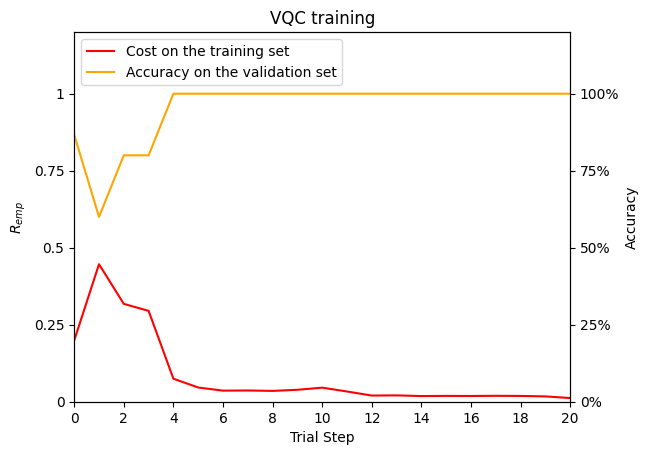

In [27]:
# Plot loss
loss_png = f"{VQC_OUT}/{TEAM_NAME}_loss.png"

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_title("VQC training")

ax1.set_xlabel("Trial Step")
ax1.set_xticks(range(0, real_iterations, 2), range(0, real_iterations, 2))
ax1.set_xlim(0, real_iterations - 1)


ax1.set_ylabel("$R_{emp}$")
ax1.set_ylim([0, 1.2])
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, 0.5, 0.75, 1])

ax2.set_ylabel("Accuracy")
ax2.set_ylim([0, 1.2])
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1], ["0%", "25%", "50%", "75%", "100%"])



cp = ax1.plot(range(real_iterations), costs, 'r', label = "Cost on the training set")
ap = ax2.plot(range(real_iterations), np.array(accuracies), 'orange', label = "Accuracy on the validation set")

lns = cp + ap
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=2)
plt.savefig(loss_png)
plt.show()

We can see that the initial cost and accuracy are rather good and this is primarily due to our warm start strategy. We also observe that the there is a quick improvement of the accuracy and loss thanks to high early stepsize. We later observe a steady and slow improvement and a convergence towards 100% thanks to the adaptative learning rate.

### <span style="color:red">TODO (4): Evaluate model on remote Braket device</span>


In [28]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"                     # SV1
# device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/dm1')            #DM1
# device = AwsDevice('arn:aws:braket:::device/qpu/ionq/ionQdevice')                     #IonQ
# device = AwsDevice('arn:aws:braket:::device/qpu/rigetti/Aspen-11')                    #Rigetti Aspen-11
# device = AwsDevice('arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2')          #Rigetti Aspen M-2

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=20,
    parallel=True,
    max_parallel=20,
    shots=500
)

qnode_remote = qml.QNode(circuit, dev_remote)

In [29]:
# Load trained parameters
loaded_params = np.loadtxt(params_csv)
final_params = loaded_params.reshape(depth + 1, n_wires, 3)

In [30]:
accuracy = evaluate(final_params, X_test, Y_test, qnode_remote)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 100.00%


In [38]:
# we made a small mistake and didn't save the preds which were used in
# the next plotting function
# But as the accuracy is 100% we can consider that the preds = Y_test
# To no re-run again on AWS and loose credits, we will just use (just for the plotting)
preds = Y_test
n_correct = len(preds)
n_incorrect = 0

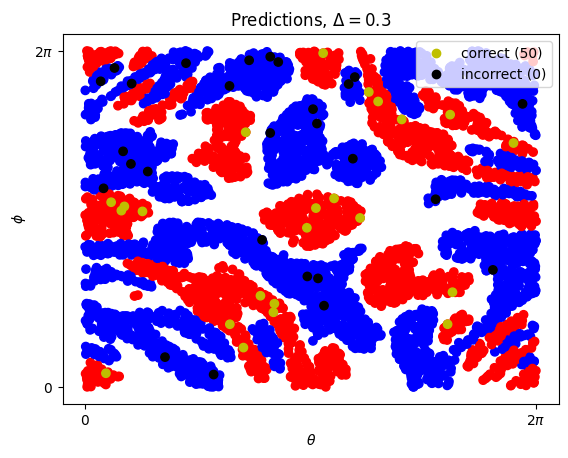

In [39]:
# Plot predictions
preds_png = f"{VQC_OUT}/{TEAM_NAME}_preds.png"

label_correct = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="y",
    markeredgecolor="y",
    label=f"correct ({n_correct})",
)
label_incorrect = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    label=f"incorrect ({n_incorrect})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1 else "b" for v in Ys])
plt.scatter(xi_test, xj_test, c=["y" if v == 1 else "k" for v in preds])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_correct, label_incorrect], loc="upper right")
plt.title(f"Predictions, $\Delta = {delta}$")
plt.savefig(preds_png)
plt.show()